# Classification

### Load and prepare data 

In [27]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, train_test_split
from sklearn.metrics import classification_report, confusion_matrix
%matplotlib inline

In [3]:
data = pd.read_csv('data_classification.csv')
data.head()

,missedDeadlinesIndex,plagiarismRatio,sinner/saint
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


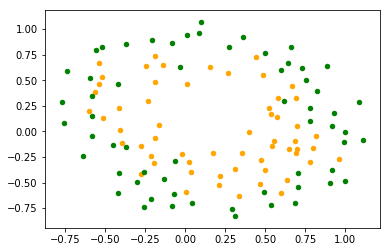

In [4]:
plt.scatter(data['plagiarismRatio'][data['sinner/saint']==1], data['missedDeadlinesIndex'][data['sinner/saint']==1], s=20, c='orange')
plt.scatter(data['plagiarismRatio'][data['sinner/saint']==0], data['missedDeadlinesIndex'][data['sinner/saint']==0], s=20, c='green')

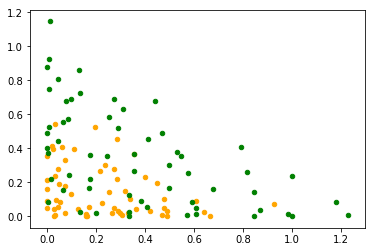

In [5]:
plt.scatter(data['plagiarismRatio'][data['sinner/saint']==1]**2, data['missedDeadlinesIndex'][data['sinner/saint']==1]**2, s=20, c='orange')
plt.scatter(data['plagiarismRatio'][data['sinner/saint']==0]**2, data['missedDeadlinesIndex'][data['sinner/saint']==0]**2, s=20, c='green')

As we can see, the data is similar to what we had in first homework therefore we will apply same methods to expand data: 

In [6]:
def expand(X):
    """
    Adds quadratic features. 
    This expansion allows your linear model to make non-linear separation.
    
    For each sample (row in matrix), compute an expanded row:
    [feature0, feature1, feature0^2, feature1^2, feature0*feature1, 1]
    
    :param X: matrix of features, shape [n_samples,2]
    :returns: expanded features of shape [n_samples,6]
    """
    X_expanded = np.zeros((X.shape[0], 6))
    for i in range(X.shape[0]):
        X_expanded[i] = np.array([X[i][0], X[i][1], X[i][0]**2, X[i][1]**2, X[i][0]*X[i][1], 1])
    return X_expanded

In [7]:
train_data, test_data = train_test_split(data, stratify=data['sinner/saint'])
train_data.reset_index(inplace=True)
test_data.reset_index(inplace=True)

In [8]:
X = data[['missedDeadlinesIndex', 'plagiarismRatio']].values
X_expanded = expand(X)
y = data['sinner/saint']

X_train = train_data[['missedDeadlinesIndex', 'plagiarismRatio']].values
X_train_expanded = expand(X_train)
y_train = train_data['sinner/saint']

X_test = test_data[['missedDeadlinesIndex', 'plagiarismRatio']].values
X_test_expanded = expand(X_test)
y_test = test_data['sinner/saint']

### Model implementation

In [9]:
def probability(X, w):
    """
    Given input features and weights
    return predicted probabilities of y==1 given x, P(y=1|x), see description above
        
    Don't forget to use expand(X) function (where necessary) in this and subsequent functions.
    
    :param X: feature matrix X of shape [n_samples,6] (expanded)
    :param w: weight vector w of shape [6] for each of the expanded features
    :returns: an array of predicted probabilities in [0,1] interval.
    """
    y_probs = np.zeros(X.shape[0])
    for i in range(X.shape[0]):
        y_probs[i] = 1/(1+np.exp(-np.dot(X[i], w)))
    return y_probs

In [10]:
def compute_loss(X, y, w, reg_type=None, lmbd=None):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute scalar loss function L using formula above.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    single_loss = lambda xi, yi, w: -(yi*np.log(probability(xi, w)) + (1-yi)*np.log(1-probability(xi, w)))
    n = X.shape[0]
    L = 1/n * np.sum([single_loss(X[i:i+1,:], y[i], w) for i in range(n)])
    
    if reg_type == 'l2':
        L+=lmbd*np.sum([weight**2 for weight in w])
    elif reg_type == 'l1':
        L+=lmbd*np.sum([abs(weight) for weight in w])
    return L

In [11]:
def compute_grad(X, y, w, reg_type=None, lmbd=None):
    """
    Given feature matrix X [n_samples,6], target vector [n_samples] of 1/0,
    and weight vector w [6], compute vector [6] of derivatives of L over each weights.
    Keep in mind that our loss is averaged over all samples (rows) in X.
    """
    n = X.shape[0]
    der_vec = 1/n * np.dot((probability(X, w) - y), X)
    
    if reg_type == 'l2':
        der_vec+=lmbd*2*w
    elif reg_type == 'l1':
        der_vec+=lmbd
    
    return der_vec

In [12]:
def predict(X,w):
    '''returns predictions'''
    pred = probability(X,w)
    return np.array([int(i) for i in pred>0.5])

### Train & compare resuls

In [13]:
# please use np.random.seed(42), eta=0.1  (learning rate), alpha=0.9 (moving average of gradient norm squared), n_iter=100 and batch_size=4 for deterministic results
def train_RMSP_log_reg(X_expanded, y, eta=0.1, alpha=0.9, eps=1e-8, n_iter=100, batch_size=4, reg_type=None, lmbd=None):
    np.random.seed(42)
    w = np.array([0, 0, 0, 0, 0, 1.])
    g2 = np.zeros(w.shape[0])
    loss = np.zeros(n_iter)
    for i in range(n_iter):
        ind = np.random.choice(X_expanded.shape[0], batch_size)
        loss[i] = compute_loss(X_expanded, y, w, reg_type=reg_type, lmbd=lmbd)
        
        gr = compute_grad(X_expanded[ind, :], y[ind], w, reg_type=reg_type, lmbd=lmbd)
        g2 = alpha*g2 + (1-alpha)*gr**2
        w = w - eta/(np.sqrt(g2+eps))*gr
    return w

In [14]:
def vizualize(X, Y, predict_fn, w=None):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = .02  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    if w is not None:
        Z = predict_fn(expand(np.c_[xx.ravel(), yy.ravel()]), w)
    else:
        Z = predict_fn(expand(np.c_[xx.ravel(), yy.ravel()]))
        

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure(1, figsize=(4, 3))
    plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, edgecolors='k', cmap=plt.cm.Paired)

    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())

    plt.show()

#### __sklearn's model:__

reg_type = l1
train accuracy:    0.7840909090909091
test_accuracy:    0.7666666666666667


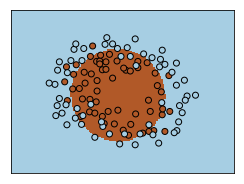

reg_type = l2
train accuracy:    0.7954545454545454
test_accuracy:    0.8


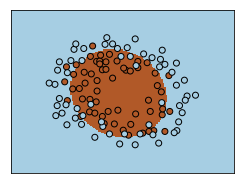

In [47]:
for reg_type in ['l1', 'l2']:
    log_reg = LogisticRegression(penalty=reg_type).fit(X_train_expanded, y_train)
    lr_train_pred = log_reg.predict(X_train_expanded)
    lr_test_pred = log_reg.predict(X_test_expanded)
    print('reg_type =', reg_type)
    print('train accuracy:   ', accuracy_score(y_train,lr_train_pred))
    print('test_accuracy:   ', accuracy_score(y_test, lr_test_pred))
    vizualize(X_expanded, y, log_reg.predict)

#### __my model:__

reg_type = l1     lambda = 0
train accuracy:    0.7840909090909091
test_accuracy:    0.7333333333333333


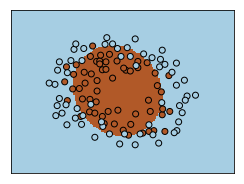

reg_type = l1     lambda = 0.001
train accuracy:    0.7954545454545454
test_accuracy:    0.7333333333333333


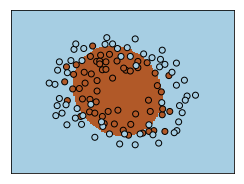

reg_type = l1     lambda = 1
train accuracy:    0.5113636363636364
test_accuracy:    0.5


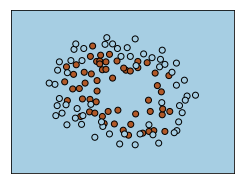

reg_type = l1     lambda = 10
train accuracy:    0.5113636363636364
test_accuracy:    0.5


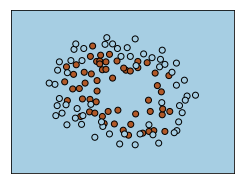

reg_type = l1     lambda = 140
train accuracy:    0.5113636363636364
test_accuracy:    0.5


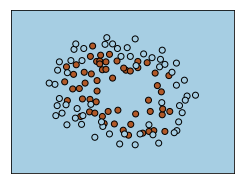

reg_type = l2     lambda = 0
train accuracy:    0.7840909090909091
test_accuracy:    0.7333333333333333


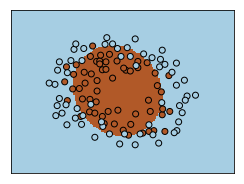

reg_type = l2     lambda = 0.001
train accuracy:    0.7727272727272727
test_accuracy:    0.7


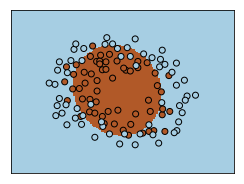

reg_type = l2     lambda = 1
train accuracy:    0.4659090909090909
test_accuracy:    0.5


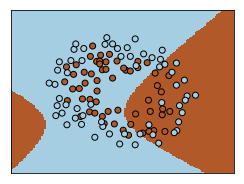

reg_type = l2     lambda = 10
train accuracy:    0.5568181818181818
test_accuracy:    0.5666666666666667


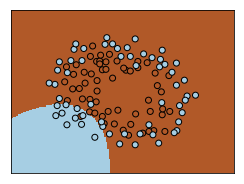

reg_type = l2     lambda = 140
train accuracy:    0.4431818181818182
test_accuracy:    0.4666666666666667


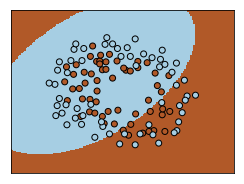

In [48]:
for reg_type in ['l1', 'l2']:
    for lmbd in [0, 0.001, 1, 10, 140]: 
        my_weights = train_RMSP_log_reg(X_train_expanded, y_train, batch_size=8, reg_type=reg_type, lmbd=lmbd)
        my_train_pred = predict(X_train_expanded, my_weights)
        my_test_pred = predict(X_test_expanded, my_weights)
        print('reg_type =', reg_type, '    lambda =', lmbd)
        print('train accuracy:   ', accuracy_score(y_train, my_train_pred))
        print('test_accuracy:   ', accuracy_score(y_test, my_test_pred))

        vizualize(X_expanded, y, predict, w=my_weights)

As we can see our model is better off without regularization. As for sklearn's model l1 seems to give worse results, as it 'deletes' some info, when assigning zero to less important features. So for datasets with not so much features, where we do not want to loose any data it is better to use l2.

### Models evaluation

#### __CV__

We can see how each model describes the data on the above plots, but for the task I will use K-fold CV with respect to class proportions of the data and LOOCV.

In [21]:
kf = StratifiedKFold(n_splits=8, shuffle=True)

In [22]:
accs = []
for train_ind, test_ind in kf.split(X_expanded, y.values):
    w = train_RMSP_log_reg(X_expanded[train_ind], y.values[train_ind], batch_size=8)
    pred = predict(X_expanded[test_ind], w) 
    accs.append(accuracy_score(y.values[test_ind], pred))
np.mean(accs)

0.735267857142857

In [24]:
LOOCV = LeaveOneOut()

In [25]:
accs = []
for train_ind, test_ind in LOOCV.split(X_expanded, y.values):
    w = train_RMSP_log_reg(X_expanded[train_ind], y.values[train_ind], batch_size=8)
    pred = predict(X_expanded[test_ind], w) 
    accs.append(accuracy_score(y.values[test_ind], pred))
np.mean(accs)

0.8050847457627118

#### __evaluation__

In [75]:
my_weights = train_RMSP_log_reg(X_train_expanded, y_train, batch_size=8)
my_train_pred = predict(X_train_expanded, my_weights)
my_test_pred = predict(X_test_expanded, my_weights)
print('train accuracy:   ', accuracy_score(y_train, my_train_pred))
print('test_accuracy:   ', accuracy_score(y_test, my_test_pred))
print('\nconfusion matrix for train:')
print(confusion_matrix(y_train, my_train_pred, labels=[1,0]))
print('\nclassification report for train:')
print(classification_report(y_train, my_train_pred))
print('\nconfusion matrix for test:')
print(confusion_matrix(y_test, my_test_pred, labels=[1,0]))
print('\nclassification report for test:')
print(classification_report(y_test, my_test_pred))

train accuracy:    0.7840909090909091
test_accuracy:    0.7333333333333333

confusion matrix for train:
[[33 10]
 [ 9 36]]

classification report for train:
             precision    recall  f1-score   support

          0       0.78      0.80      0.79        45
          1       0.79      0.77      0.78        43

avg / total       0.78      0.78      0.78        88


confusion matrix for test:
[[ 9  6]
 [ 2 13]]

classification report for test:
             precision    recall  f1-score   support

          0       0.68      0.87      0.76        15
          1       0.82      0.60      0.69        15

avg / total       0.75      0.73      0.73        30



* confusion matrix:
 - TP - True positives, classifier predicted saint and the sudent was saint
 - TN - True negatives, classifier predicted sinner and the sudent was sinner
 - FP - False positives, classifier predicted saint and the sudent was sinner
 - FN - False negatives, classifier predicted sinner and the sudent was saint
* precision - TP / TP+FP, proportion of the students that our model says were saint actually were saint
* recall - TP / TP+FN, ability to find all saints in all students
* f1-score - single metric that combines recall and precision using the harmonic mean